In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [84]:
# Relative Importance Index 

import pandas as pd

custom_colors = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2",
    "#D55E00", "#CC79A7", "#999999", "#F4A582", "#92C5DE",
    "#B2182B", "#2166AC"
]

# Load the data
df1 = pd.read_csv('TABASCO_CAMPECHE_fishing_reports.csv', low_memory=False)
df2 = pd.read_csv('AVISOS_MAYORES_2017_2023.csv', low_memory=True)

# Rename the column for consistency
df1.rename(columns={'NOMBRE PRINCIPAL': 'Fish Name'}, inplace=True)
df2.rename(columns={'NOMBRE PRINCIPAL': 'Fish Name'}, inplace=True)

# Function to calculate IIR and return the DataFrame
def calculate_iir(df):
    # Create a new column for the value of the catch
    df['Value (MXN)'] = df['PESO DESEMBARCADO_KILOGRAMOS'] * df['PRECIO_PESOS']

    # 1. Identify the top 10 Fish Name by their catch volume in PESO DESEMBARCADO_KILOGRAMOS
    by_volume = df.groupby('Fish Name')['PESO DESEMBARCADO_KILOGRAMOS'].sum()

    # 2. Identify the top 10 Fish Name by the value of the catch
    by_value = df.groupby('Fish Name')['Value (MXN)'].sum()

    # 3. Identify the frequency with which each Fish Name of the top 10 by volume is reported
    by_frequency = df[df['Fish Name'].isin(by_volume.index)]['Fish Name'].value_counts()

    # Calculate the percentage of catch, value, and frequency
    total_volume = df['PESO DESEMBARCADO_KILOGRAMOS'].sum()
    total_value = df['Value (MXN)'].sum()
    total_reports = len(df)

    percent_volume = by_volume / total_volume * 100
    percent_value = by_value / total_value * 100
    percent_frequency = by_frequency / total_reports * 100

    # Create a DataFrame for the percentages
    iir_df = pd.DataFrame({
        'Fish Name': by_volume.index,
        '% Capture': percent_volume.values,
        '% Value': percent_value.reindex(by_volume.index).values,
        '% Frequency': percent_frequency.reindex(by_volume.index).values
    })

    # Calculate the Relative Importance Index (IIR)
    iir_df['IIR'] = (iir_df['% Capture'] + iir_df['% Value'] + iir_df['% Frequency']) / 3

    # Sort by IIR in descending order
    iir_df = iir_df.sort_values(by='IIR', ascending=False)

    return iir_df

# Calculate IIR for both dataframes
iir_df1 = calculate_iir(df1)
iir_df2 = calculate_iir(df2)

# Display the top 10 species by IIR for each dataframe
top_10_iir_df1 = iir_df1.head(10)
top_10_iir_df2 = iir_df2.head(10)

# Display the final tables
print("Top 10 Species by IIR for df1:")
print(top_10_iir_df1)

print("\nTop 10 Species by IIR for df2:")
print(top_10_iir_df2)


Top 10 Species by IIR for df1:
      Fish Name  % Capture    % Value  % Frequency        IIR
37        PULPO  14.933884  31.032931    10.527434  18.831417
39       ROBALO   5.654748  14.964799    11.028048  10.549199
22        JUREL  12.828586   4.434041    11.276598   9.513075
32        OTRAS   6.223576   7.151608    10.421529   7.932238
4       BANDERA   6.673365   3.150506     4.099158   4.641010
30      MOJARRA   3.511136   4.264117     5.138883   4.304712
42        RUBIO   2.971109   1.737526     7.399474   4.036036
31       OSTION  10.300612   0.817124     0.642939   3.920225
21        JAIBA   5.979985   3.089487     2.327201   3.798891
20  GUACHINANGO   2.174257   5.525041     2.906246   3.535181

Top 10 Species by IIR for df2:
    Fish Name  % Capture    % Value  % Frequency        IIR
43    SARDINA  56.138778  17.028797    13.215230  28.794268
12    CAMARON   1.731753  24.885908    26.143241  17.586968
31      OTRAS   1.406902  15.675072    14.032771  10.371582
2        ATUN  

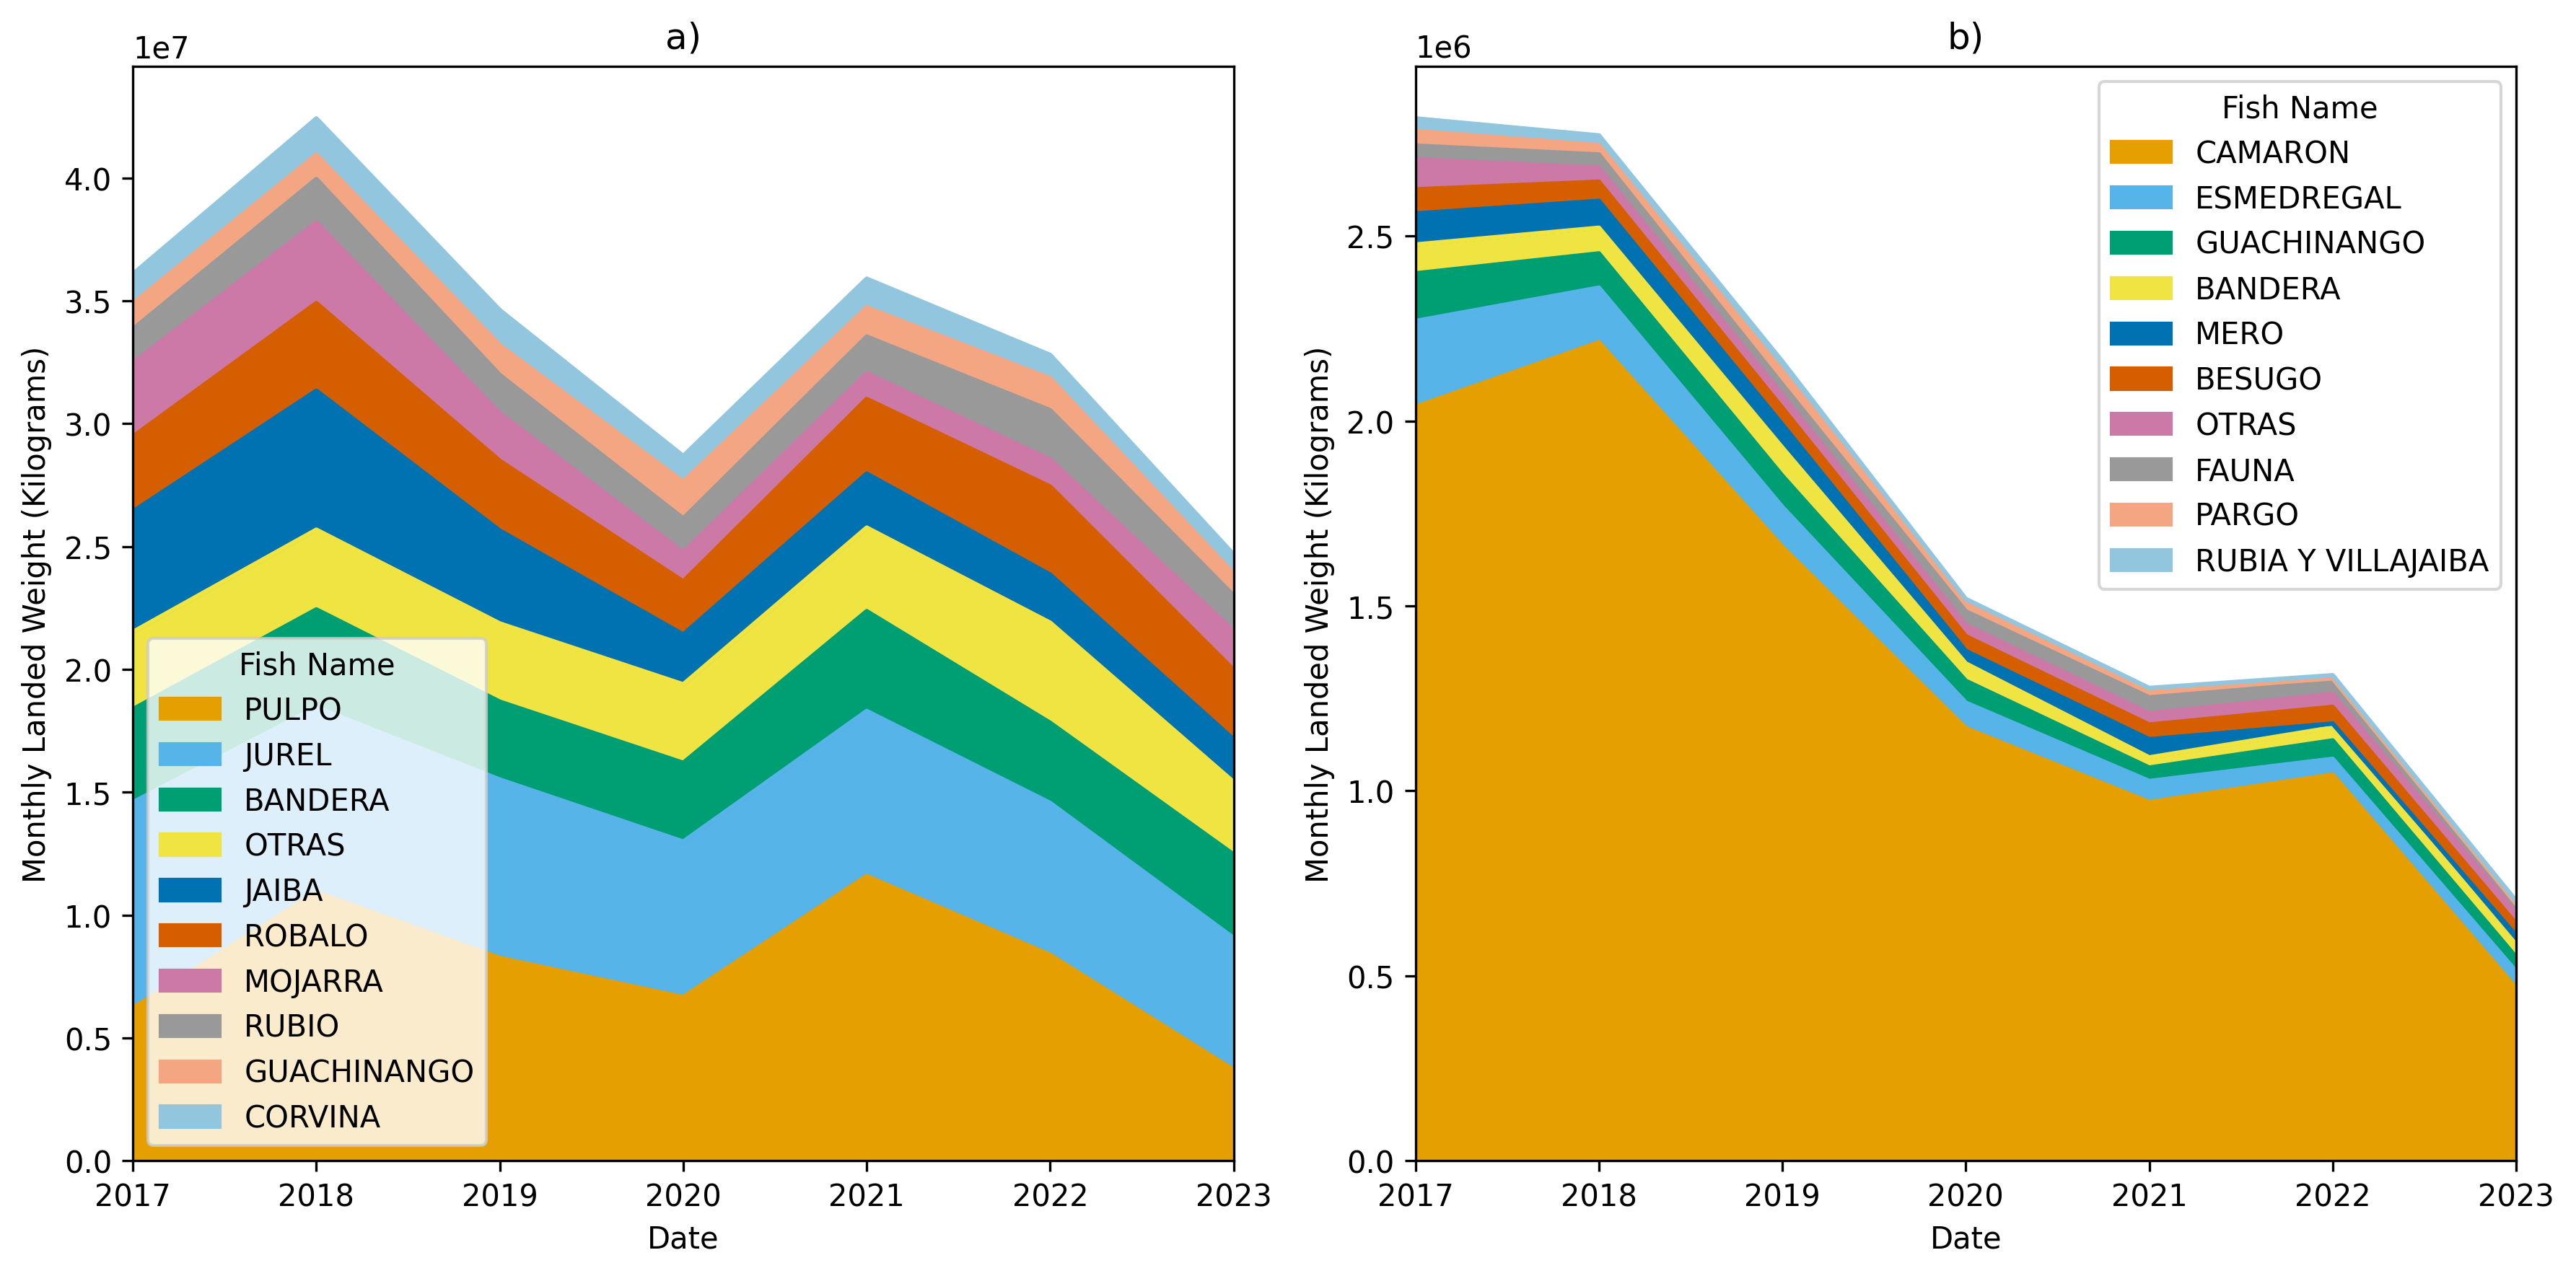

In [85]:
#Time series Catches

# Rename the column before any operations
df1.rename(columns={'NOMBRE PRINCIPAL': 'Fish Name'}, inplace=True)

# Preprocess the first dataframe
df1['FECHA AVISO'] = pd.to_datetime(df1['FECHA AVISO'], format='%d/%m/%Y')
df1['YEAR'] = df1['FECHA AVISO'].dt.year
df1['MONTH'] = df1['FECHA AVISO'].dt.month
df1 = df1[df1['YEAR'] != 2016]
df1 = df1[df1['Fish Name'] != 'OSTION']
df1['NOMBRE OFICINA'] = df1['NOMBRE OFICINA'].replace('SANCHEZ MAGALLANES', 'SANCHEZ MAGALLANEZ')
df1['Value (MXN)'] = df1['PESO DESEMBARCADO_KILOGRAMOS'] * df1['PRECIO_PESOS']

# Identify top 10 species by volume and value
by_volume1 = df1.groupby('Fish Name')['PESO DESEMBARCADO_KILOGRAMOS'].sum()
by_value1 = df1.groupby('Fish Name')['Value (MXN)'].sum()
by_frequency1 = df1[df1['Fish Name'].isin(by_volume1.index)]['Fish Name'].value_counts()

# Calculate percentages
total_volume1 = df1['PESO DESEMBARCADO_KILOGRAMOS'].sum()
total_value1 = df1['Value (MXN)'].sum()
total_reports1 = len(df1)

percent_volume1 = by_volume1 / total_volume1 * 100
percent_value1 = by_value1 / total_value1 * 100
percent_frequency1 = by_frequency1 / total_reports1 * 100

# Create DataFrame for percentages and IIR
iir_df1 = pd.DataFrame({
    'Fish Name': by_volume1.index,
    '% Capture': percent_volume1.values,
    '% Value': percent_value1.reindex(by_volume1.index).values,
    '% Frequency': percent_frequency1.reindex(by_volume1.index).values
})

iir_df1['IIR'] = (iir_df1['% Capture'] + iir_df1['% Value'] + iir_df1['% Frequency']) / 3
iir_df1 = iir_df1.sort_values(by='IIR', ascending=False)

top_10_species_df1 = df1[df1['Fish Name'].isin(iir_df1['Fish Name'].head(10))]
monthly_df1 = top_10_species_df1.groupby([pd.Grouper(key='FECHA AVISO', freq='YE'), 'Fish Name'])['PESO DESEMBARCADO_KILOGRAMOS'].sum().unstack().fillna(0)
ordered_columns1 = monthly_df1.sum().sort_values(ascending=False).index
monthly_df1 = monthly_df1[ordered_columns1]

# Preprocess the second dataframe
df2.rename(columns={'NOMBRE PRINCIPAL': 'Fish Name'}, inplace=True)
df2 = df2[(df2['NOMBRE ESTADO'] == 'TABASCO') | (df2['NOMBRE ESTADO'] == 'CAMPECHE')]
df2['FECHA AVISO'] = pd.to_datetime(df2['FECHA AVISO'], format='%d/%m/%Y')
df2['YEAR'] = df2['FECHA AVISO'].dt.year
df2['MONTH'] = df2['FECHA AVISO'].dt.month
df2 = df2[df2['YEAR'] != 2016]
df2 = df2[df2['Fish Name'] != 'OSTION']
df2['NOMBRE OFICINA'] = df2['NOMBRE OFICINA'].replace('SANCHEZ MAGALLANES', 'SANCHEZ MAGALLANEZ')
df2['Value (MXN)'] = df2['PESO DESEMBARCADO_KILOGRAMOS'] * df2['PRECIO_PESOS']

# Identify top 10 species by volume and value
by_volume2 = df2.groupby('Fish Name')['PESO DESEMBARCADO_KILOGRAMOS'].sum()
by_value2 = df2.groupby('Fish Name')['Value (MXN)'].sum()
by_frequency2 = df2[df2['Fish Name'].isin(by_volume2.index)]['Fish Name'].value_counts()

# Calculate percentages
total_volume2 = df2['PESO DESEMBARCADO_KILOGRAMOS'].sum()
total_value2 = df2['Value (MXN)'].sum()
total_reports2 = len(df2)

percent_volume2 = by_volume2 / total_volume2 * 100
percent_value2 = by_value2 / total_value2 * 100
percent_frequency2 = by_frequency2 / total_reports2 * 100

# Create DataFrame for percentages and IIR
iir_df2 = pd.DataFrame({
    'Fish Name': by_volume2.index,
    '% Capture': percent_volume2.values,
    '% Value': percent_value2.reindex(by_volume2.index).values,
    '% Frequency': percent_frequency2.reindex(by_volume2.index).values
})

iir_df2['IIR'] = (iir_df2['% Capture'] + iir_df2['% Value'] + iir_df2['% Frequency']) / 3
iir_df2 = iir_df2.sort_values(by='IIR', ascending=False)

top_10_species_df2 = df2[df2['Fish Name'].isin(iir_df2['Fish Name'].head(10))]
monthly_df2 = top_10_species_df2.groupby([pd.Grouper(key='FECHA AVISO', freq='YE'), 'Fish Name'])['PESO DESEMBARCADO_KILOGRAMOS'].sum().unstack().fillna(0)
ordered_columns2 = monthly_df2.sum().sort_values(ascending=False).index
monthly_df2 = monthly_df2[ordered_columns2]

# Plot the monthly time series with stacked areas
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), dpi=300)

monthly_df1.plot.area(stacked=True, color=custom_colors[:len(monthly_df1.columns)], ax=axes[0])
axes[0].set_title('a)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Monthly Landed Weight (Kilograms)')

monthly_df2.plot.area(stacked=True, color=custom_colors[:len(monthly_df2.columns)], ax=axes[1])
axes[1].set_title('b)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Monthly Landed Weight (Kilograms)')

plt.tight_layout()
plt.show()


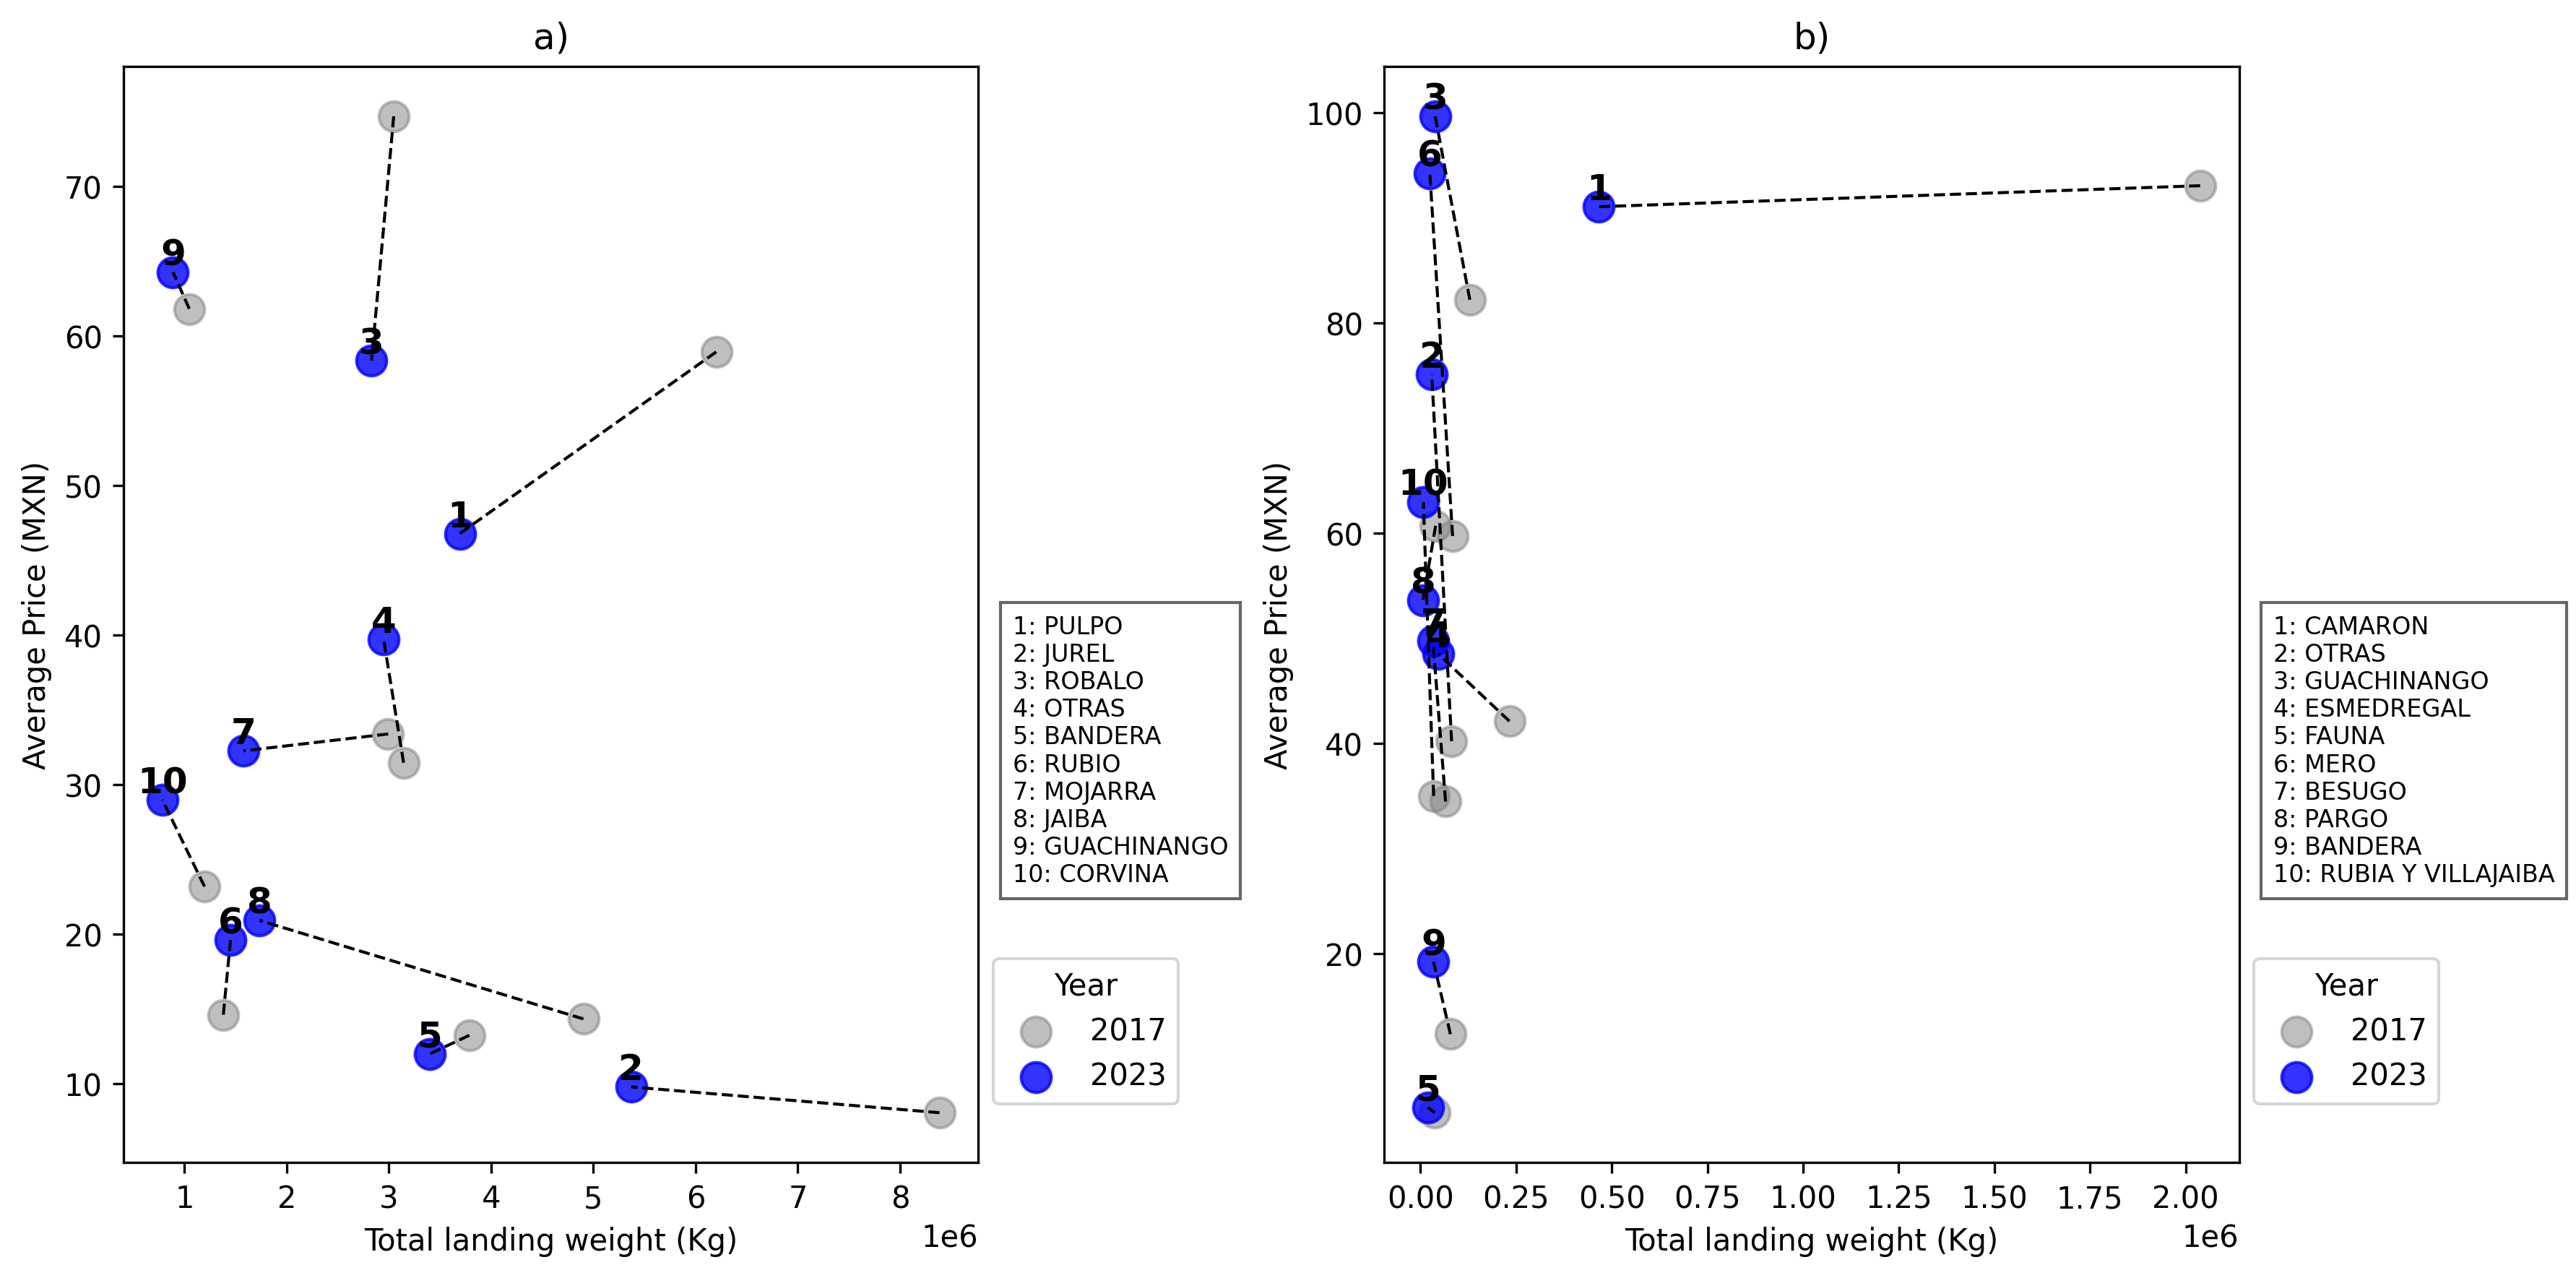

In [86]:
#Comparation by catch and prices between years 2017 and 2023


# Function to preprocess and calculate IIR for a given DataFrame


def preprocess_and_calculate_IIR(df, year_col='YEAR', fish_col='Fish Name', weight_col='PESO DESEMBARCADO_KILOGRAMOS', price_col='PRECIO_PESOS', date_col='FECHA AVISO'):
    df[date_col] = pd.to_datetime(df[date_col], format='%d/%m/%Y')
    df[year_col] = df[date_col].dt.year
    df['MONTH'] = df[date_col].dt.month
    df = df[df[year_col] != 2016]
    df = df[df[fish_col] != 'OSTION']
    df['NOMBRE OFICINA'] = df['NOMBRE OFICINA'].replace('SANCHEZ MAGALLANES', 'SANCHEZ MAGALLANEZ')
    df['Value (MXN)'] = df[weight_col] * df[price_col]

    # Calculate IIR for all species
    species_summary = df.groupby(fish_col).agg({
        weight_col: 'sum',
        price_col: 'mean',
        fish_col: 'count'
    }).rename(columns={
        weight_col: 'Total Peso Desembarcado (KG)',
        price_col: 'Precio Promedio (MXN)',
        fish_col: 'Frecuencia de Registro'
    }).reset_index()

    # Calculate IIR
    percent_volume = (species_summary['Total Peso Desembarcado (KG)'] / species_summary['Total Peso Desembarcado (KG)'].sum()) * 100
    percent_value = (species_summary['Precio Promedio (MXN)'] / species_summary['Precio Promedio (MXN)'].sum()) * 100
    percent_frequency = (species_summary['Frecuencia de Registro'] / species_summary['Frecuencia de Registro'].sum()) * 100
    species_summary['IIR'] = (percent_volume + percent_value + percent_frequency) / 3

    # Filter top 10 species by IIR and assign labels 1 to 10
    top_species_summary = species_summary.nlargest(10, 'IIR').reset_index(drop=True)
    top_species_summary['Label'] = range(1, 11)

    # Extract data for the years 2017 and 2023
    data_2017 = df[(df[year_col] == 2017) & (df[fish_col].isin(top_species_summary[fish_col]))]
    data_2023 = df[(df[year_col] == 2023) & (df[fish_col].isin(top_species_summary[fish_col]))]

    # Calculate summary statistics for 2017 and 2023
    summary_2017 = data_2017.groupby(fish_col).agg({
        weight_col: 'sum',
        price_col: 'mean'
    }).rename(columns={
        weight_col: 'Total Peso Desembarcado (KG) 2017',
        price_col: 'Precio Promedio (MXN) 2017'
    }).reset_index()

    summary_2023 = data_2023.groupby(fish_col).agg({
        weight_col: 'sum',
        price_col: 'mean'
    }).rename(columns={
        weight_col: 'Total Peso Desembarcado (KG) 2023',
        price_col: 'Precio Promedio (MXN) 2023'
    }).reset_index()

    # Merge 2017 and 2023 summaries
    merged_summary = pd.merge(summary_2017, summary_2023, on=fish_col, suffixes=('_2017', '_2023'))
    merged_summary = pd.merge(merged_summary, top_species_summary[[fish_col, 'Label']], on=fish_col)

    return merged_summary, top_species_summary

# Preprocess dataframes and calculate IIR
merged_summary1, top_species_summary1 = preprocess_and_calculate_IIR(df1)
merged_summary2, top_species_summary2 = preprocess_and_calculate_IIR(df2)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), dpi=300)

# Function to create the scatter plot for each DataFrame
def plot_scatter(ax, merged_summary, top_species_summary, title):
    for i, row in merged_summary.iterrows():
        ax.scatter(row['Total Peso Desembarcado (KG) 2017'], row['Precio Promedio (MXN) 2017'], color='gray', alpha=0.5, marker='o', s=100, label='2017' if i == 0 else "")
        ax.scatter(row['Total Peso Desembarcado (KG) 2023'], row['Precio Promedio (MXN) 2023'], color='blue', alpha=0.8, marker='o', s=100, label='2023' if i == 0 else "")
        ax.plot([row['Total Peso Desembarcado (KG) 2017'], row['Total Peso Desembarcado (KG) 2023']], 
                [row['Precio Promedio (MXN) 2017'], row['Precio Promedio (MXN) 2023']], 
                'k--', lw=1)
        ax.text(row['Total Peso Desembarcado (KG) 2023'], row['Precio Promedio (MXN) 2023'], str(row['Label']),
                 fontsize=12, ha='center', va='bottom', color='black', fontweight='bold')

    # Add species list with codes as a legend
    legend_text = "\n".join([f"{row['Label']}: {row['Fish Name']}" for i, row in top_species_summary.iterrows()])
    ax.text(1.04, 0.5, legend_text, transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6))

    # Add labels and title
    ax.set_xlabel('Total landing weight (Kg)')
    ax.set_ylabel('Average Price (MXN)')
    ax.set_title(title)
    
    # Add legend for years outside the plot
    ax.legend(title="Year", loc="upper left", bbox_to_anchor=(1, 0.2))

# Plot the data
plot_scatter(axes[0], merged_summary1, top_species_summary1, 'a)')
plot_scatter(axes[1], merged_summary2, top_species_summary2, 'b)')

plt.tight_layout()
plt.show()


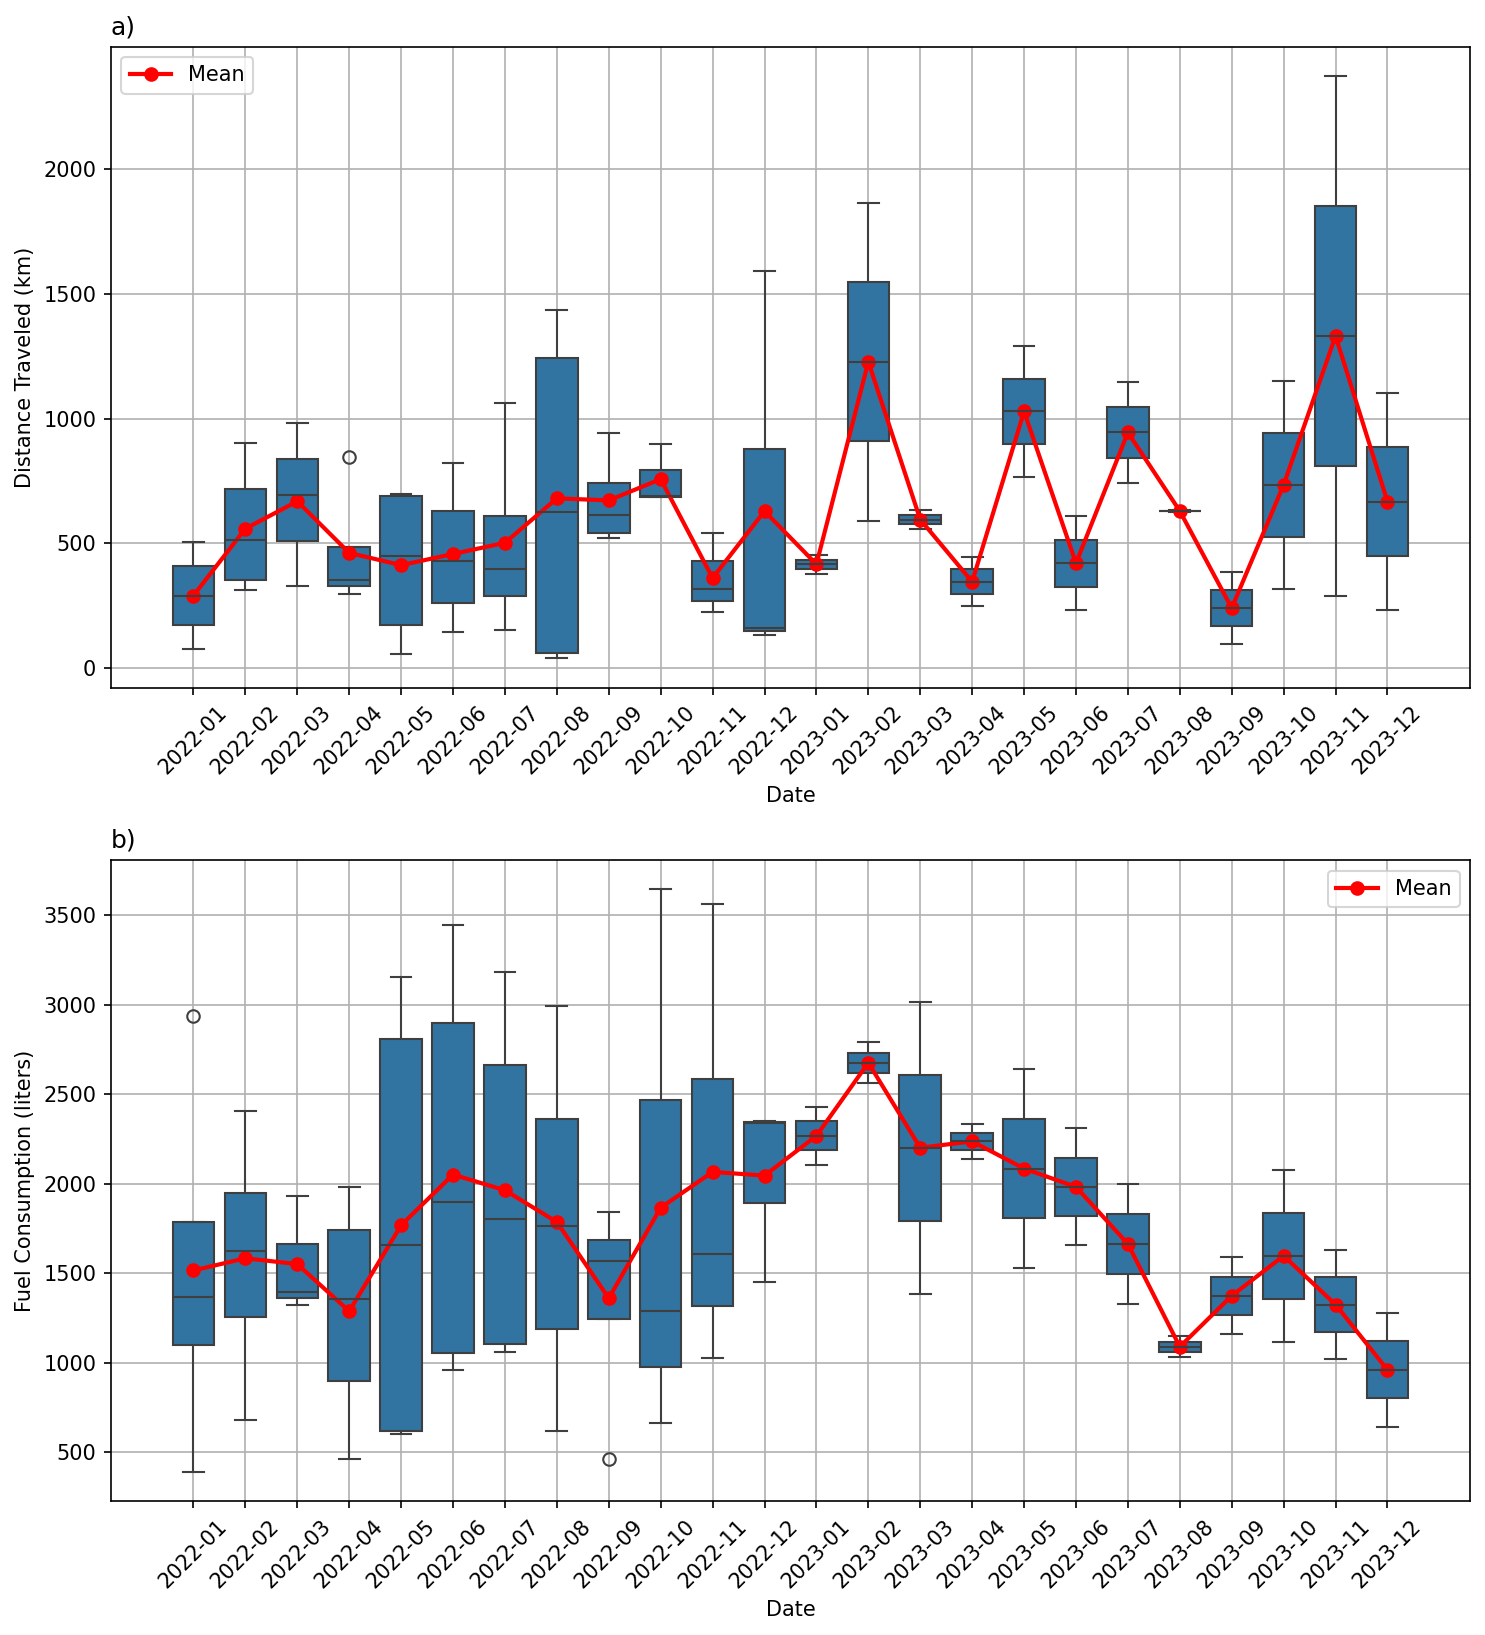

In [87]:
# Small scale fleet with Nemos analisys

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Convert date and time columns to datetime
df['Guardar_Marca'] = pd.to_datetime(df['Guardar_Marca'], errors='coerce')

# Filter points with speed equal to 0
df = df[df['Etapa_Viaje'] != 'Amarre']

# Sort the data by vessel and time
df = df.sort_values(by=['Nombre_Embarcacion', 'Guardar_Marca'])

# Create a geometry column from longitude and latitude columns
df['geometry'] = [Point(xy) for xy in zip(df.Longitud, df.Latitud)]
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Calculate the distance between consecutive points in time for each vessel
def calculate_distance(row):
    if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
        return 0
    return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

# Shift the coordinates and time to get the previous point and time
gdf['Latitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Latitud'].shift()
gdf['Longitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Longitud'].shift()
gdf['Guardar_Marca_prev'] = gdf.groupby('Nombre_Embarcacion')['Guardar_Marca'].shift()

# Apply the distance calculation
gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

# Calculate the time difference in hours
gdf['Tiempo_horas'] = (gdf['Guardar_Marca'] - gdf['Guardar_Marca_prev']).dt.total_seconds() / 3600

# Replace NaN in distance and time columns with 0
gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

# Calculate fuel consumption (liters) based on engine power and operation time

liters_per_hour = 36.9
# engine_power_hp = 100

gdf['Consumo_litros'] = gdf['Tiempo_horas'] * liters_per_hour
# Identify and remove outliers in fuel consumption
# Here, an outlier is defined as any value above the 99th percentile
q_upper = gdf['Consumo_litros'].quantile(0.99)
gdf = gdf[gdf['Consumo_litros'] <= q_upper]

# Create a year-month column
gdf['YearMonth'] = gdf['Guardar_Marca'].dt.to_period('M')

# Calculate the total distance traveled, fuel consumption, and hours at sea monthly for each vessel
monthly_distance_fuel = gdf.groupby(['Nombre_Embarcacion', 'YearMonth']).agg({
    'Distancia_km': 'sum',
    'Consumo_litros': 'sum',
    'Tiempo_horas': 'sum'
}).reset_index()

# Calculate the monthly averages of distance traveled, fuel consumption, and time at sea
mean_distance = monthly_distance_fuel.groupby('YearMonth')['Distancia_km'].mean()
mean_fuel = monthly_distance_fuel.groupby('YearMonth')['Consumo_litros'].mean()

# Plot the boxplots in a single figure
fig, axes = plt.subplots(2, 1, figsize=(10, 11), dpi=150)

# Plot a boxplot of the monthly distance traveled for all vessels
sns.boxplot(ax=axes[0], x='YearMonth', y='Distancia_km', data=monthly_distance_fuel)
axes[0].plot(mean_distance.index.astype(str), mean_distance.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')
axes[0].set_title('a)', loc='left')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Distance Traveled (km)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)
axes[0].legend()

# Plot a boxplot of the monthly fuel consumption for all vessels
sns.boxplot(ax=axes[1], x='YearMonth', y='Consumo_litros', data=monthly_distance_fuel)
axes[1].plot(mean_fuel.index.astype(str), mean_fuel.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean')
axes[1].set_title('b)', loc='left')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Fuel Consumption (liters)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



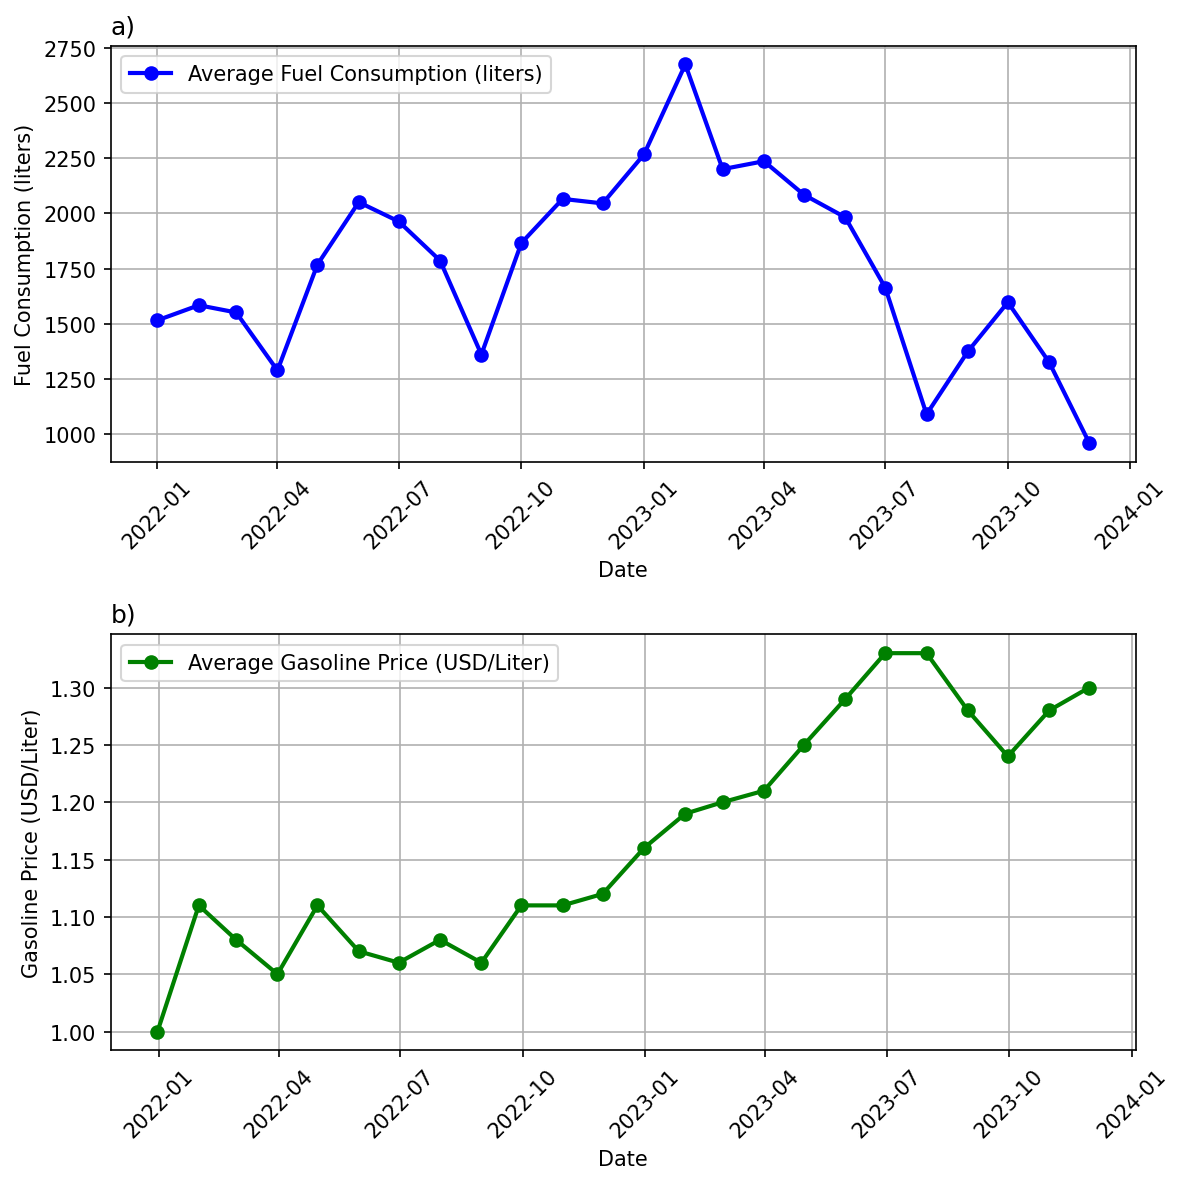

In [88]:
# Fuel consumtion rate estimation
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic
import seaborn as sns

# Cargar el archivo CSV
df_vms = pd.read_csv('vms_flota_nemo.csv', low_memory=False)

# Convertir las columnas de fecha y hora a datetime
df_vms['Guardar_Marca'] = pd.to_datetime(df_vms['Guardar_Marca'], errors='coerce')

# Filtrar los puntos con velocidad igual a 0
df_vms = df_vms[df_vms['Etapa_Viaje'] != 'Amarre']

# Ordenar los datos por embarcación y tiempo
df_vms = df_vms.sort_values(by=['Nombre_Embarcacion', 'Guardar_Marca'])

# Crear una columna de geometría a partir de las columnas de longitud y latitud
df_vms['geometry'] = [Point(xy) for xy in zip(df_vms.Longitud, df_vms.Latitud)]
gdf = gpd.GeoDataFrame(df_vms, geometry='geometry')

# Calcular la distancia entre puntos consecutivos en el tiempo para cada embarcación
def calculate_distance(row):
    if pd.isnull(row['Latitud_prev']) or pd.isnull(row['Longitud_prev']):
        return 0
    return geodesic((row['Latitud'], row['Longitud']), (row['Latitud_prev'], row['Longitud_prev'])).km

# Shift the coordinates and time to get the previous point and time
gdf['Latitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Latitud'].shift()
gdf['Longitud_prev'] = gdf.groupby('Nombre_Embarcacion')['Longitud'].shift()
gdf['Guardar_Marca_prev'] = gdf.groupby('Nombre_Embarcacion')['Guardar_Marca'].shift()

# Apply the distance calculation
gdf['Distancia_km'] = gdf.apply(calculate_distance, axis=1)

# Calculate the time difference in hours
gdf['Tiempo_horas'] = (gdf['Guardar_Marca'] - gdf['Guardar_Marca_prev']).dt.total_seconds() / 3600

# Reemplazar NaN en las columnas de distancia y tiempo con 0
gdf['Distancia_km'] = gdf['Distancia_km'].fillna(0)
gdf['Tiempo_horas'] = gdf['Tiempo_horas'].fillna(0)

# Calcular el consumo de gasolina (litros) basado en la potencia del motor y el tiempo de operación

liters_per_houriters = 36.9

gdf['Consumo_litros'] = gdf['Tiempo_horas'] * liters_per_hour

# Identificar y eliminar valores anómalos en el consumo de gasolina
# Aquí, se define como anómalo cualquier valor que esté por encima del percentil 99
q_upper = gdf['Consumo_litros'].quantile(0.99)
gdf = gdf[gdf['Consumo_litros'] <= q_upper]

# Crear una columna de año-mes
gdf['YearMonth'] = gdf['Guardar_Marca'].dt.to_period('M').dt.to_timestamp()

# Calcular la distancia total recorrida, el consumo de gasolina y las horas en el mar mensualmente por cada embarcación
distancia_consumo_mensual = gdf.groupby(['Nombre_Embarcacion', 'YearMonth']).agg({
    'Distancia_km': 'sum',
    'Consumo_litros': 'sum',
    'Tiempo_horas': 'sum'
}).reset_index()

# Calcular las medias mensuales de distancia recorrida, consumo de gasolina y tiempo en el mar
medias_distancia = distancia_consumo_mensual.groupby('YearMonth')['Distancia_km'].mean()
medias_consumo = distancia_consumo_mensual.groupby('YearMonth')['Consumo_litros'].mean()
medias_tiempo = distancia_consumo_mensual.groupby('YearMonth')['Tiempo_horas'].mean()

# Datos del precio de la gasolina en México (USD/Litro)
data_gas = {
    'Date': pd.date_range(start='2021-12-01', periods=24, freq='ME'),
    'Price (USD/Liter)': [1.00, 1.11, 1.08, 1.05, 1.11, 1.07, 1.06, 1.08, 1.06, 1.11, 1.11, 1.12,
                          1.16, 1.19, 1.20, 1.21, 1.25, 1.29, 1.33, 1.33, 1.28, 1.24, 1.28, 1.30]
}

df_gas = pd.DataFrame(data_gas)

# Asegurar que las fechas coinciden exactamente
medias_consumo = medias_consumo.reset_index()
medias_consumo['YearMonth'] = pd.to_datetime(medias_consumo['YearMonth'])
df_gas['Date'] = pd.to_datetime(df_gas['Date'])

# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), dpi=150)

# Graficar el promedio de consumo de gasolina
ax1.plot(medias_consumo['YearMonth'], medias_consumo['Consumo_litros'], color='blue', marker='o', linestyle='-', linewidth=2, label='Average Fuel Consumption (liters)')
ax1.set_title('a)',loc='left')
ax1.set_xlabel('Date')
ax1.set_ylabel('Fuel Consumption (liters)')
ax1.legend(loc='upper left')
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Graficar el precio promedio de la gasolina
ax2.plot(df_gas['Date'], df_gas['Price (USD/Liter)'], color='green', marker='o', linestyle='-', linewidth=2, label='Average Gasoline Price (USD/Liter)')
ax2.set_title('b)',loc='left')
ax2.set_xlabel('Date')
ax2.set_ylabel('Gasoline Price (USD/Liter)')
ax2.legend(loc='upper left')
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
